In [1]:
!pip install yfinance

In [2]:
from pandas_datareader import data
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
yf.pdr_override()

Step 1 :Get the data

In [3]:
df=data.get_data_yahoo(tickers="000001.SS",start="2013-01-01",end="2022-12-31")
df=df['Close']
df
#mtr=data.get_data_yahoo(tickers="ETH-USD",start="2013-01-01",end="2022-12-31")

[*********************100%%**********************]  1 of 1 completed


Date
2013-01-04    2276.991943
2013-01-07    2285.364014
2013-01-08    2276.070068
2013-01-09    2275.340088
2013-01-10    2283.656982
                 ...     
2022-12-26    3065.562988
2022-12-27    3095.570068
2022-12-28    3087.399902
2022-12-29    3073.699951
2022-12-30    3089.260010
Name: Close, Length: 2427, dtype: float64

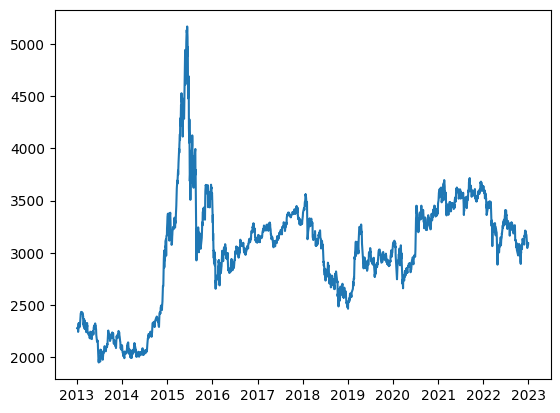

In [4]:
plt.plot(df)

Step 2: Prepare the data

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
rdata=scaler.fit_transform(np.array(df).reshape(-1,1))
rdata
# by the mapping (x-x.min)/(x.max-x.min)

array([[0.10166219],
       [0.10426517],
       [0.10137557],
       ...,
       [0.35362822],
       [0.34936874],
       [0.35420655]])

In [6]:
# 80% for training, 20% for testing
training_size=int(len(rdata)*0.8)
train_period,test_period=rdata[0:training_size,:],rdata[training_size:len(rdata),:]
train_period

array([[0.10166219],
       [0.10426517],
       [0.10137557],
       ...,
       [0.44997537],
       [0.44430152],
       [0.45531311]])

In [7]:
#One window lasts for 14 days, and the 15th day is labeled
#Retrieve data from the first 10 days
from keras.preprocessing.sequence import TimeseriesGenerator
train = TimeseriesGenerator(train_period, train_period, length=14, batch_size=500)
test = TimeseriesGenerator(test_period, test_period, length=14, batch_size=500)
X_train, y_train = list(train)[0][0][:, :10], list(train)[0][1]
X_test, y_test = list(test)[0][0][:, :10], list(test)[0][1]

Step 3: Build the model and train

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

In [32]:
model=Sequential()
model.add(LSTM(10,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='MAE',optimizer='ADAM')#MAE
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 10)            480       
                                                                 
 lstm_13 (LSTM)              (None, 10, 100)           44400     
                                                                 
 lstm_14 (LSTM)              (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 75131 (293.48 KB)
Trainable params: 75131 (293.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
#train the model
model.fit(X_train,y_train,epochs=40,batch_size=64,verbose=1)

Epoch 1/40
8/8 [==============================] - 6s 28ms/step - loss: 0.0710
Epoch 2/40
8/8 [==============================] - 0s 29ms/step - loss: 0.0469
Epoch 3/40
8/8 [==============================] - 0s 29ms/step - loss: 0.0292
Epoch 4/40
8/8 [==============================] - 0s 29ms/step - loss: 0.0252
Epoch 5/40
8/8 [==============================] - 0s 30ms/step - loss: 0.0230
Epoch 6/40
8/8 [==============================] - 0s 28ms/step - loss: 0.0221
Epoch 7/40
8/8 [==============================] - 0s 31ms/step - loss: 0.0222
Epoch 8/40
8/8 [==============================] - 0s 28ms/step - loss: 0.0219
Epoch 9/40
8/8 [==============================] - 0s 28ms/step - loss: 0.0214
Epoch 10/40
8/8 [==============================] - 0s 29ms/step - loss: 0.0215
Epoch 11/40
8/8 [==============================] - 0s 30ms/step - loss: 0.0218
Epoch 12/40
8/8 [==============================] - 0s 30ms/step - loss: 0.0215
Epoch 13/40
8/8 [==============================] - 0s 28ms/st

Step 4: Predict the price for the testing data set

In [34]:
#inverse-map (0,1) to the ture stock preies
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict2=scaler.inverse_transform(train_predict)
test_predict2=scaler.inverse_transform(test_predict)
y_train2=scaler.inverse_transform(y_train)
y_test2=scaler.inverse_transform(y_test)
#print(len(test_predict),len(y_test))

15/15 [==============================] - 0s 7ms/step


Step 5: Plot the actual/prediction graph and calculate the accuracy of the prediction

In [35]:
#loss
diff_sum = sum(abs(x - y) for x, y in zip(test_predict2, y_test2))
print(diff_sum)

[35268.25219727]


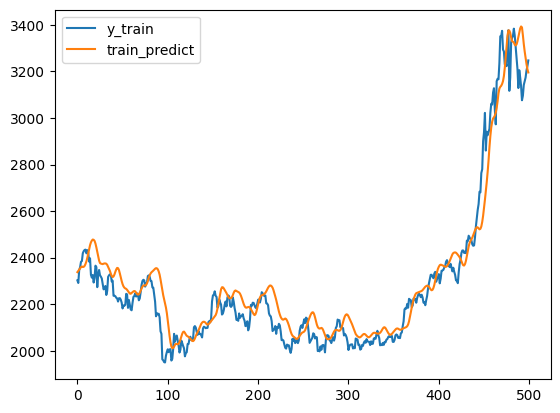

In [36]:
plt.figure()
plt.plot(y_train2, label='y_train')
plt.plot(train_predict2, label='train_predict')
plt.legend()
plt.show()

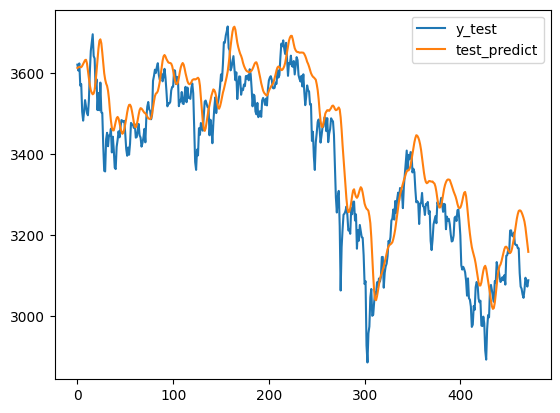

In [ ]:
plt.figure()
plt.plot(y_test2, label='y_test')
plt.plot(test_predict2, label='test_predict')
plt.legend()
plt.show()